# Прогнозирование поведения клиента

#### Импортируем нужные библиотеки

In [ ]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive

from scipy.optimize import minimize
from sklearn.metrics import r2_score

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

#### Выгружаем данные с винтажами

In [ ]:
df = pd.read_csv(
    'data_vintages.csv',
    sep=";",
    encoding="cp1251",
    index_col=0,
    date_parser=lambda x: pd.to_datetime(x), #преобразуем даты
    parse_dates=['gen_month_dt', 'gen_quarter_dt']
)
df.head(10)

/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
5,13089,14,2019-03-01,2019-01-01,0,0,0,1,0,0,0,1
6,132017,7,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0
7,67966,24,2019-06-01,2019-04-01,1,0,0,0,1,0,0,0
8,152759,11,2019-11-01,2019-10-01,0,0,1,1,0,0,0,1
9,128462,20,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0


In [ ]:
len(df)

2493268

In [ ]:
df1 = df[:int(len(df)/2)]
df2 = df[int(len(df)/2):]
df2.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
1246634,2558,6,2019-02-01,2019-01-01,0,0,0,1,0,0,0,1
1246635,128342,2,2019-08-01,2019-07-01,0,0,0,1,0,0,0,1
1246636,177443,22,2019-11-01,2019-10-01,1,0,0,0,1,0,0,0
1246637,189513,12,2020-02-01,2020-01-01,0,0,0,1,0,0,0,1
1246638,142249,8,2019-09-01,2019-07-01,1,0,0,0,1,0,0,0


In [ ]:
df1.to_csv('data_vintages1.csv', index=False)
df2.to_csv('data_vintages2.csv', index=False)

In [ ]:
df1_read = pd.read_csv('data_vintages2.csv')
df1_read.head()

,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg
0,2558,6,2019-02-01,2019-01-01,0,0,0,1,0,0,0,1
1,128342,2,2019-08-01,2019-07-01,0,0,0,1,0,0,0,1
2,177443,22,2019-11-01,2019-10-01,1,0,0,0,1,0,0,0
3,189513,12,2020-02-01,2020-01-01,0,0,0,1,0,0,0,1
4,142249,8,2019-09-01,2019-07-01,1,0,0,0,1,0,0,0


#### Выгружаем данные со скорами для дальнейшей разбивки на бакеты

In [ ]:
df_scores = pd.read_csv(
    'data_scores.csv',
    sep=";",
    encoding="cp1251",
    decimal=',',
    index_col=0
)

df_scores.head(10)

,user_id,pd,x_score
0,9311,0.035025,0.219980
1,155026,0.046279,0.146986
2,17584,0.007221,0.343298
3,156231,0.069679,0.186684
4,123587,0.010402,0.305582
5,125519,0.032667,0.261228
6,123890,0.027963,0.199389
7,82137,0.073694,0.113313
8,55227,0.011746,0.335474
9,124825,0.049237,0.227262


#### Бъем выборку на бакеты и джойним с данными с винтажами

In [ ]:
df_scores = df_scores.sort_values(['pd'], ignore_index=True)
df_scores['pd_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['pd_bucket'])['pd'].mean())

df_scores = df_scores.sort_values(['x_score'], ignore_index=True)
df_scores['x_bucket'] = np.minimum(df_scores.index // (df_scores.shape[0]//3),2)
print(df_scores.groupby(['x_bucket'])['x_score'].mean())

df = df.merge(df_scores[['user_id', 'pd_bucket', 'x_bucket', 'pd', 'x_score']], how='left', on='user_id').dropna()
df.head()

pd_bucket
0    0.011040
1    0.032685
2    0.068209
Name: pd, dtype: float64
x_bucket
0    0.133270
1    0.220838
2    0.379452
Name: x_score, dtype: float64


,user_id,statement_num,gen_month_dt,gen_quarter_dt,clo_flg,def_flg,dlq_flg,act_flg,prev_clo_flg,prev_def_flg,prev_dlq_flg,prev_act_flg,pd_bucket,x_bucket,pd,x_score
0,127336,19,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,2,0.021296,0.469410
1,35907,16,2019-04-01,2019-04-01,1,0,0,0,1,0,0,0,2,0,0.064742,0.157215
2,45228,21,2019-05-01,2019-04-01,0,0,0,1,0,0,0,1,0,2,0.018490,0.469583
3,39035,23,2019-07-01,2019-07-01,0,0,0,1,0,0,0,1,1,1,0.025882,0.210896
4,130780,19,2019-08-01,2019-07-01,1,0,0,0,1,0,0,0,1,1,0.024330,0.269492


### Построим винтажи кривой def ratio

Винтаж: значения исследуемого параметра для фиксированного поколения (месяца/квартала прихода в портфель) в зависимости от номера платежа клиента в портфеле

Default ratio - доля клиентов в дефолте (просрочке 4+):
### $$ DEF ratio_n = \frac{\#Def_n}{\#cnt_n}$$


In [ ]:
# Выгружаем таблицу

default_ratio_data = (df.groupby(["gen_quarter_dt", "statement_num"])     # группировка по поколению и месяцу жизни клиента
        .agg({"def_flg":np.mean})                                         # считаем средний уровень дефолта
        .rename(columns = {"def_flg": 'default_ratio'})                   # переименовываем столбец со средними значениями
        .unstack('gen_quarter_dt'))                                       # разворачиваем таблицу, столбцы теперь поколения
default_ratio_data

default_ratio                                            
gen_quarter_dt    2019-01-01 2019-04-01 2019-07-01 2019-10-01 2020-01-01
statement_num                                                           
1                   0.000000   0.000000   0.000000   0.000000   0.000000
2                   0.000000   0.000000   0.000000   0.000000   0.000000
3                   0.000000   0.000000   0.000000   0.000000   0.000000
4                   0.024648   0.023479   0.022953   0.020854   0.021494
5                   0.029873   0.028222   0.027104   0.024146   0.025497
6                   0.035211   0.033960   0.031645   0.028537   0.030609
7                   0.042026   0.040752   0.037925   0.033049   0.036152
8                   0.047592   0.045465   0.042642   0.037927   0.039970
9                   0.053158   0.051293   0.048141   0.042073   0.044466
10                  0.059178   0.056883   0.053604   0.047439   0.049209
11                  0.064630   0.062330   0.060238   0.051098   0.054259
12                  0.068946   0.068739   0.066624   0.053601   0.060048
13                  0.073489   0.074799   0.072229   0.057564   0.064790
14                  0.079850   0.082353   0.076486   0.061833   0.068301
15                  0.086211   0.088120   0.079892   0.065919   0.071195
16                  0.091549   0.093243   0.084752   0.069516   0.074460
17                  0.097910   0.097459   0.089258   0.072017   0.077970
18                  0.102908   0.102143   0.093444   0.075188   0.079818
19                  0.107338   0.105978   0.097843   0.078115   0.082589
20                  0.111313   0.110838   0.101142   0.081042   0.085114
21                  0.115402   0.114995   0.104654   0.082627   0.087393
22                  0.119037   0.119474   0.107457   0.084273   0.089733
23                  0.122899   0.123163   0.110331   0.085554   0.091519
24                  0.126761   0.126120   0.112920   0.087505   0.093250

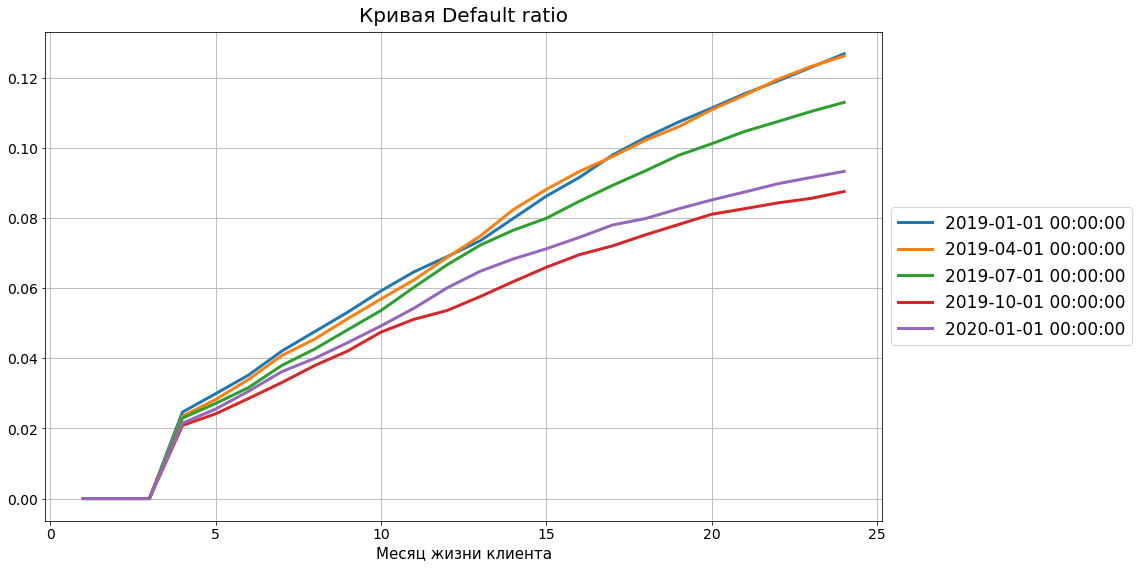

In [ ]:
def plot_default_ratio_by_generation(df):
    return (df.groupby(["gen_quarter_dt", "statement_num"])
            .agg({"def_flg":np.mean})
            .rename(columns = {"def_flg": 'default_ratio'})
            .unstack('gen_quarter_dt')
            ['default_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))

# Строим график при помощи pyplot
plot_default_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выберем переменную, которая делит кривые наилучшим образом

 Будем искать переменную, в разбивке по которой кривые def ratio будут сильнее всего отличаться друг от друга. Это позволит нам лучше разделять клиентов между собой с точки зрения доходности.

#### Разделение кривых по PD
PD - вероятность дефлота (просрочки 4+) за первые 12 платежей по кредиту

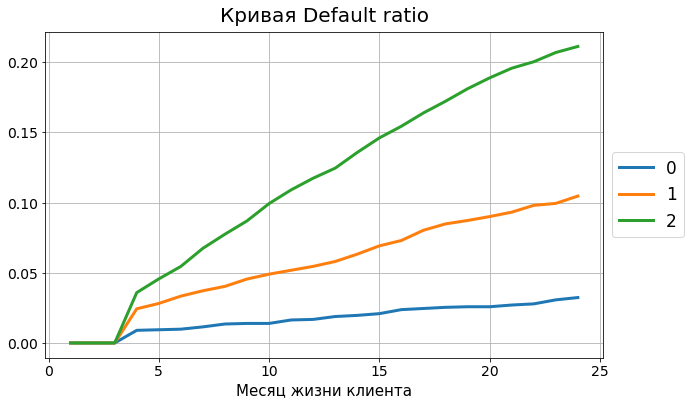

In [ ]:
def plot_default_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_quarter_dt == '2019-01-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"def_flg":np.mean})
            .rename(columns = {"def_flg": 'default_ratio'})
            .unstack(bucket)
            ['default_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_default_ratio_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Разделение получилось достаточно сильным

#### Разделение кривых по переменной X

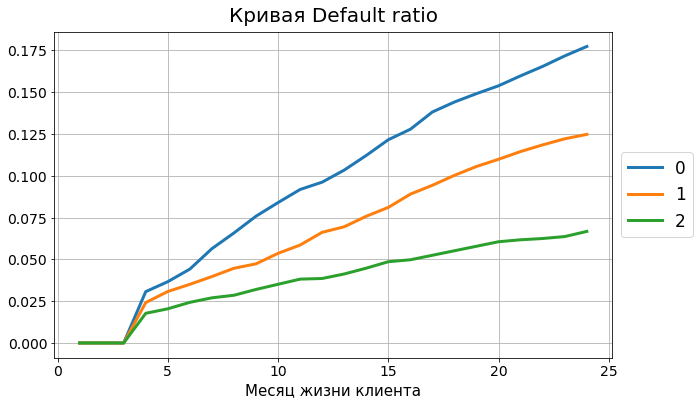

In [ ]:
plot_default_ratio_by_bucket(df, 'x_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Разделение по переменной Х получилось хуже, чем по PD.

#### Итог: В данном случае для разделение кривых выберем PD.

## Анализ странных поколений

Отрисуем распределение данных во времени по бакетам PD

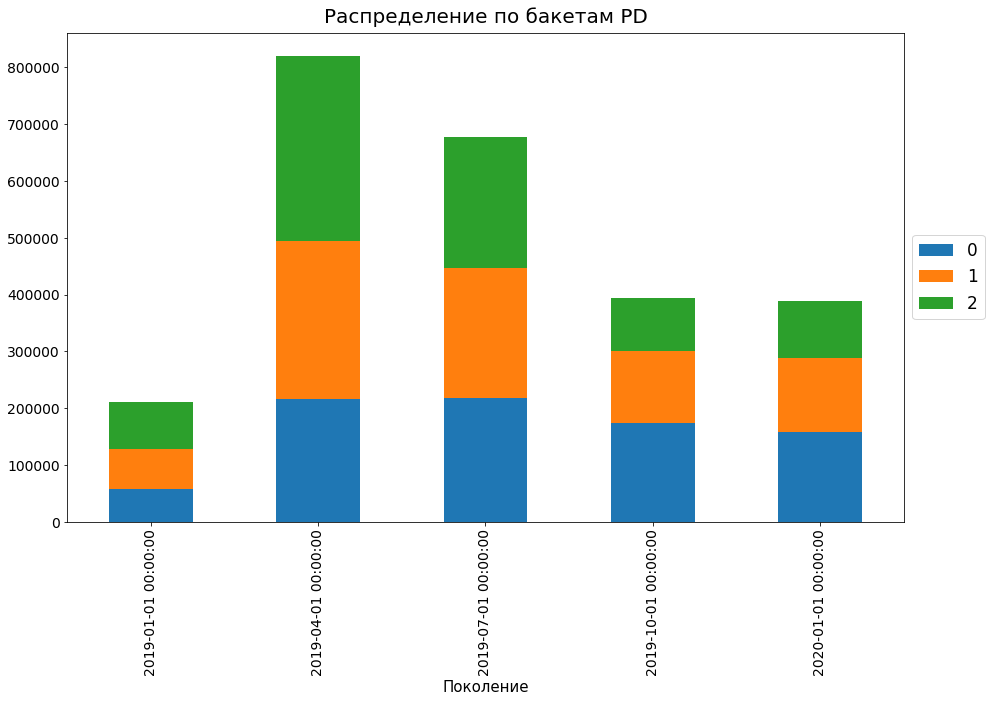

In [ ]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_quarter_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'pd_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

В 1 квартале 2019 года данных не так много, как в остальных, но достаточно для анализа. Никакие поколения и бакеты выбрасывать не будем.

### Кривые Def Rate по бакетам PD

## $$ Def Rate_n = \frac{\#Def_n}{\#Act_{n-1}} $$

interactive(children=(Dropdown(description='pd_bucket', options=(0, 1, 2), value=0), Output()), _dom_classes=(…

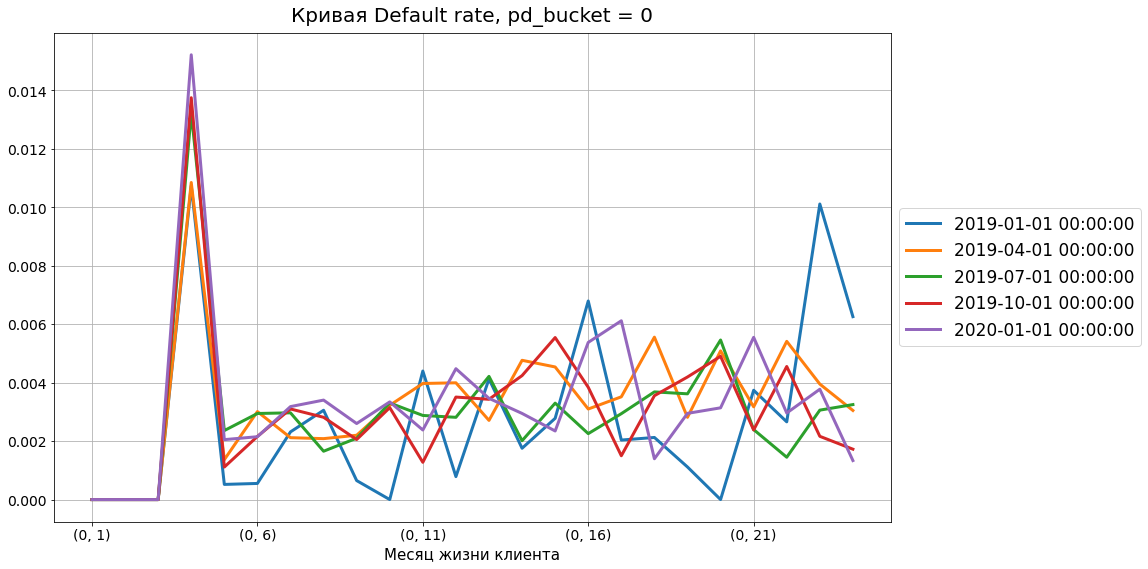

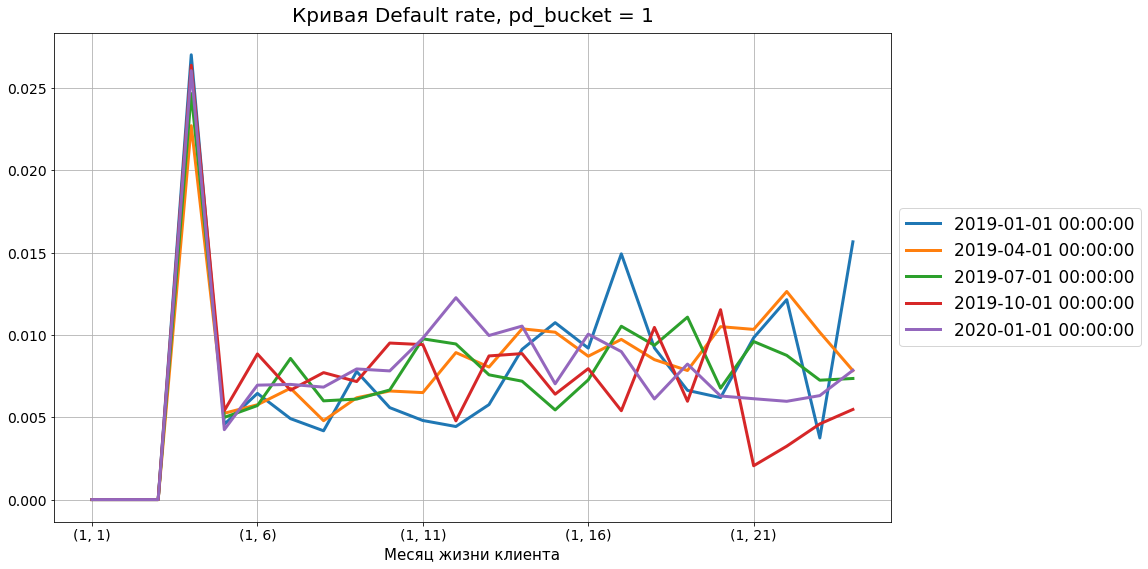

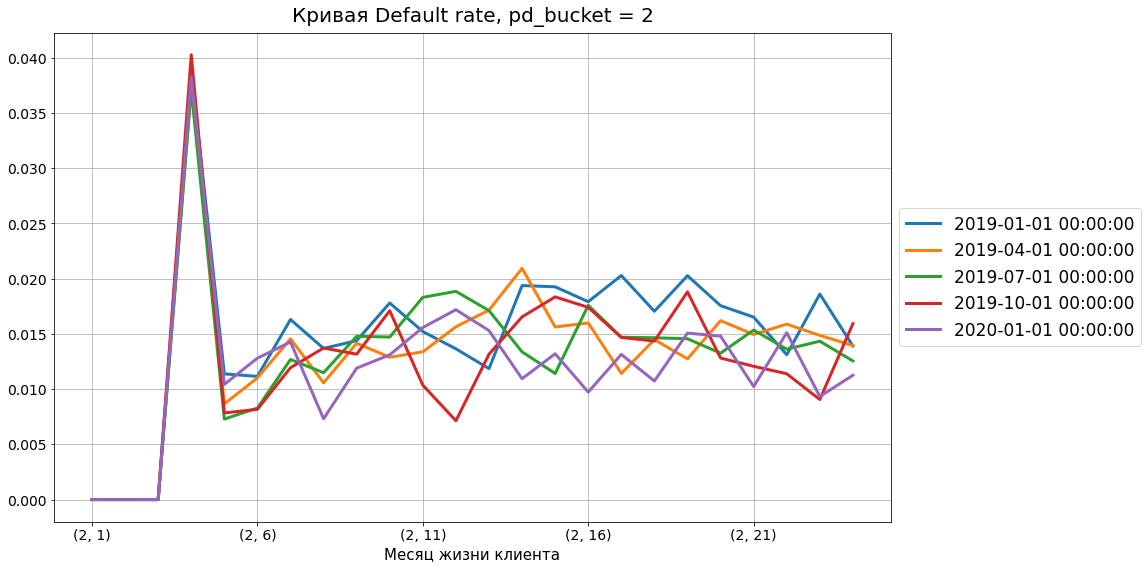

In [ ]:
%matplotlib inline
# Выгружаем таблицу c винтажами

default_rate_data = df.eval('def_new_flg = def_flg * prev_act_flg', inplace=False)\
    .groupby(["gen_quarter_dt", 'pd_bucket', "statement_num"])\
    .agg({"def_new_flg":np.sum, "prev_act_flg":np.sum, "user_id":np.count_nonzero})\
    .rename(columns = ({"def_new_flg":'def_cnt', "prev_act_flg":'prev_act_cnt', "user_id":"cnt"}))\
    .eval('default_rate = def_cnt / prev_act_cnt', inplace=False)


# Делаем список бакетов

buckets = df['pd_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_default_rate_by_generation(pd_bucket):

    cur_df = default_rate_data.query('pd_bucket == ' + str(pd_bucket))
    (cur_df.unstack('gen_quarter_dt')
            ['default_rate']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Default rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)


# Отображаем его при помощи ipywidget, чтобы получить интерактивность

vintages_graph = interactive(plot_default_rate_by_generation, pd_bucket = buckets)
vintages_graph

Поколение января 2019 вносит шум в бакете 0. Исключим его из рассмотрения в этом бакете.

#### Далее построим среднее по бакетам.

interactive(children=(Dropdown(description='pd_bucket', options=(1, 2, 0), value=1), Output()), _dom_classes=(…

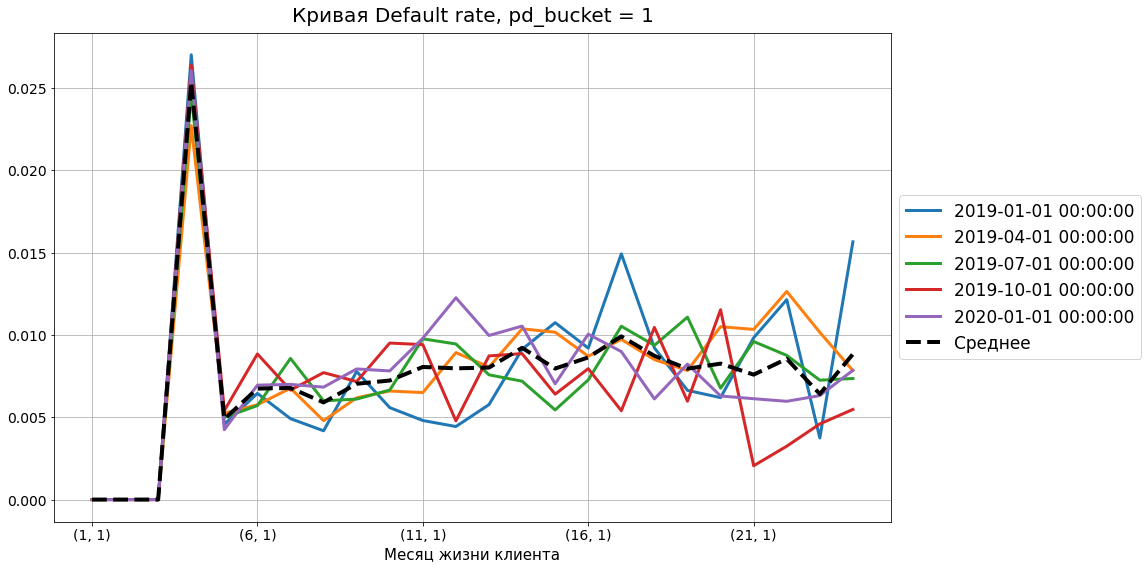

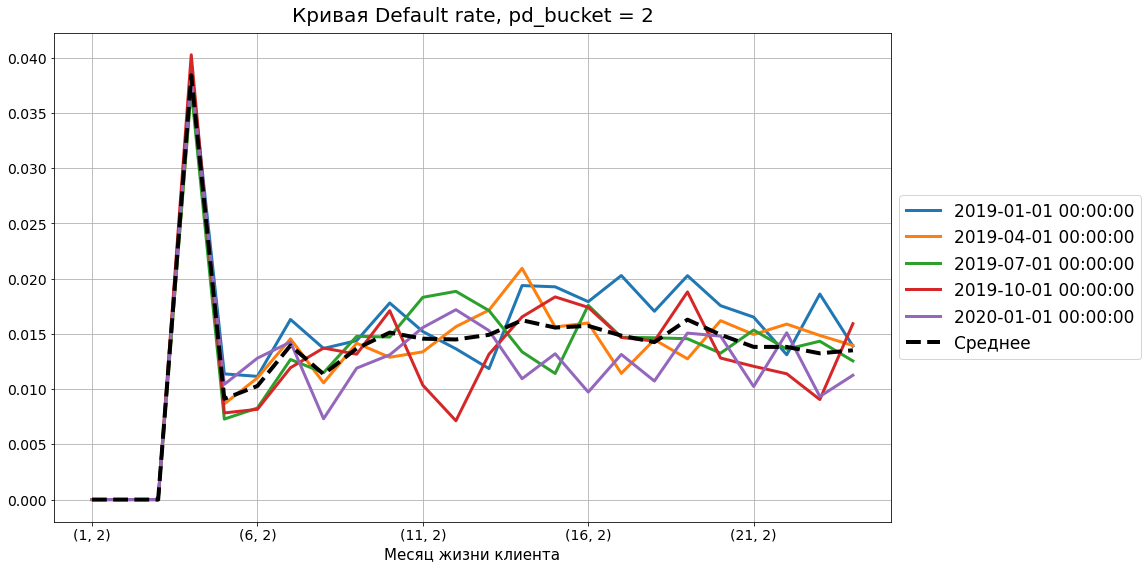

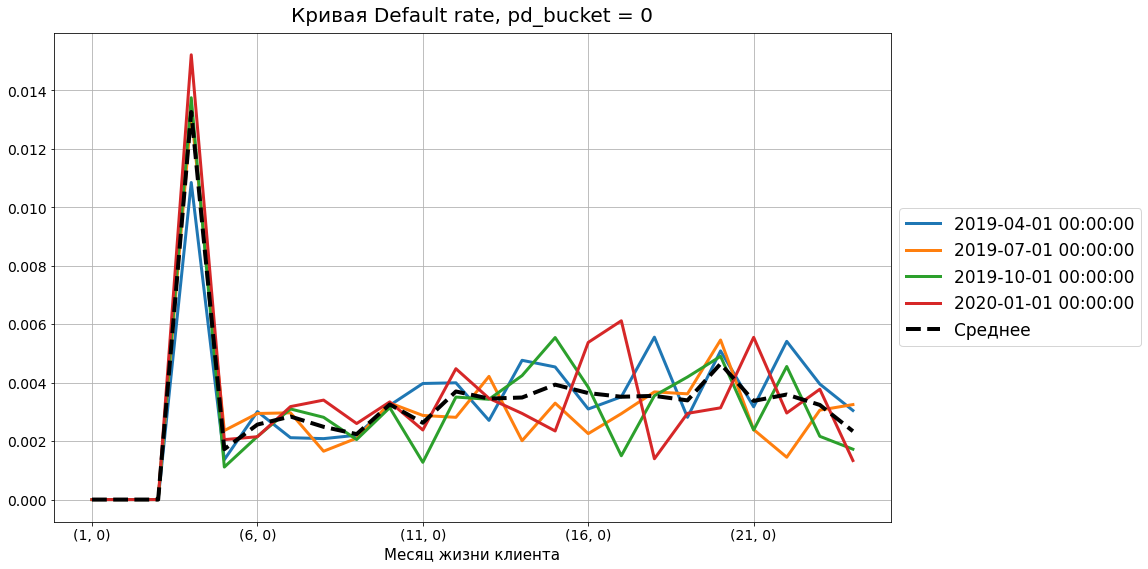

In [ ]:
# Исключаем "странные" поколения

exception_query = ''' ~((gen_quarter_dt == '2019-01-01') & (pd_bucket == 0)) '''
default_rate_data.query(exception_query, inplace = True)

# Считаем среднее

default_rate_mean = default_rate_data.groupby(['statement_num', 'pd_bucket'])\
    .agg({'default_rate':np.mean})\
    .rename(columns = {'default_rate':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_default_rate_mean(pd_bucket):
    vintages_graph = default_rate_data.query('pd_bucket == ' + str(pd_bucket))\
            .unstack('gen_quarter_dt')\
            ['default_rate']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (default_rate_mean.query('pd_bucket == ' + str(pd_bucket))
            ['Среднее']
            .plot(ax=vintages_graph, figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Default rate, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

vintages_graph = interactive(plot_default_rate_mean, pd_bucket = buckets)
vintages_graph

### Сглаживание средних кривых

Рассмотрим сглаживание на примере одного бакета PD

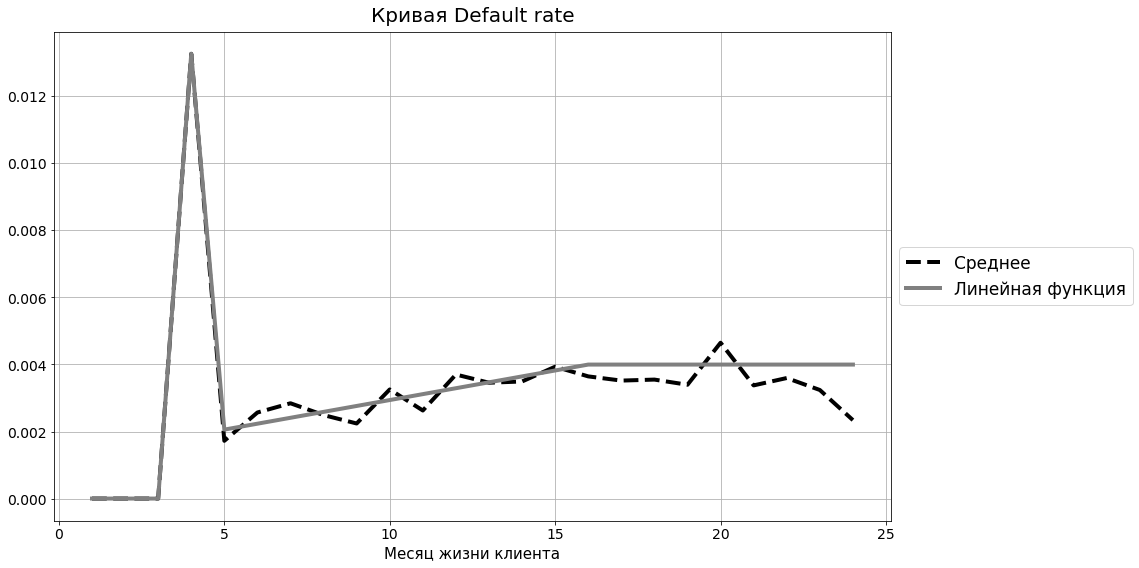

In [ ]:
def linear_approximation(df, start=1, finish=24):
    df_res = pd.DataFrame(df)
    df_res['Линейная функция'] = df['Среднее']                                                # Копируем средние значения
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], 1)  # Коэффициенты уравнения прямой
    linear_coeff = np.poly1d(linear_coeff)                                                    # Превращаем коэффициенты в функцию
    df_res.loc[start:finish, 'Линейная функция'] = linear_coeff(np.arange(start, finish+1))   # Записываем приближение
    df_res.loc[finish+1:, 'Линейная функция'] = linear_coeff(finish+1)                        # Продолжаем кривую константой
    return df_res

# Делаем аппроксимацию

df_linear = default_rate_mean.query('pd_bucket == 0').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 5, 15)

# Строим получившийся график

plt.figure(figsize=(15, 9))
df_linear['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_linear['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

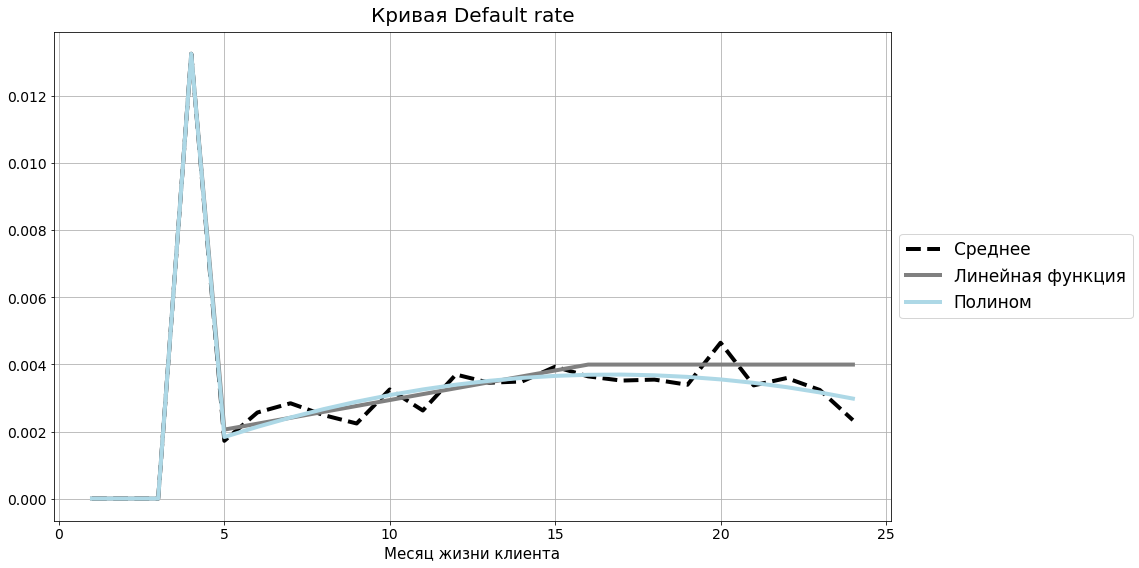

In [ ]:
def polynom_approximation(df, start=1, finish=20, degree = 1):
    df_res = pd.DataFrame(df)
    df_res['Полином'] = df['Среднее']
    linear_coeff = np.polyfit(np.arange(start, finish+1),df.loc[start:finish, 'Среднее'], degree)  # Здесь произвольная степень
    linear_coeff = np.poly1d(linear_coeff)
    df_res.loc[start:finish, 'Полином'] = linear_coeff(np.arange(start, finish+1))
    df_res.loc[finish+1:, 'Полином'] = linear_coeff(finish+1)
    return df_res


# Делаем полиномиальную аппроксимацию
df_polynom = polynom_approximation(df_linear, 5,24,2)

# Строим получившиеся графики вместе
plt.figure(figsize=(15, 9))
df_polynom['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_polynom['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_polynom['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

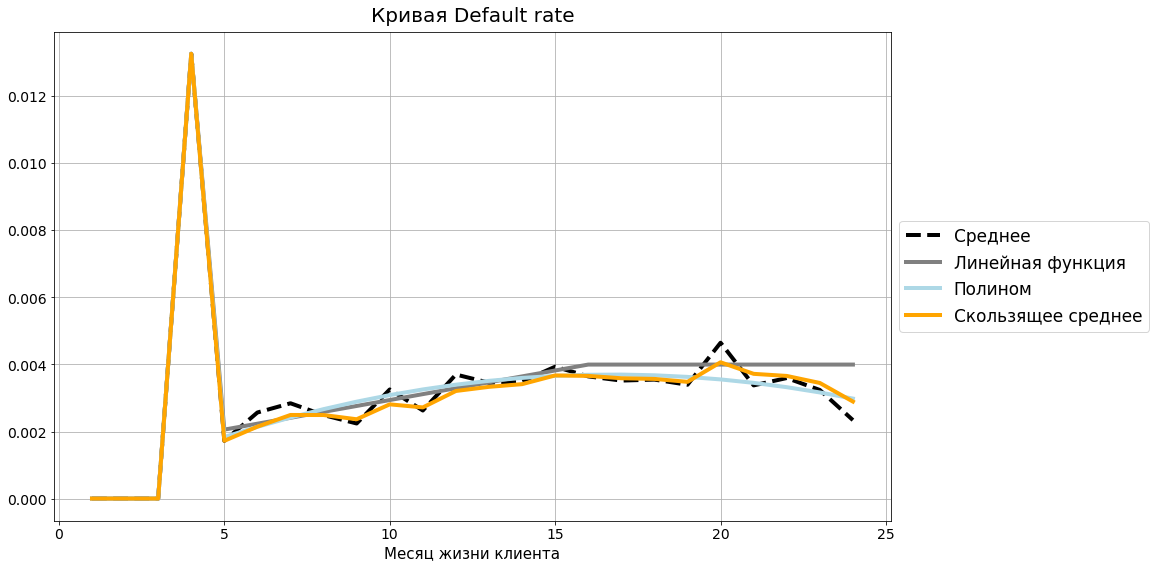

In [ ]:
def exponential_smoothing(df, start, finish, alpha):
    df_res = pd.DataFrame(df)
    result = [df_res.loc[i,'Среднее'] for i in np.arange(1,start+1)]                              # Начальные значения копируем
    for n in range(start, len(df_res['Среднее'])):
        result.append(float(alpha * df_res.loc[n + 1, 'Среднее'] + (1 - alpha) * result[n-1]))    # Делаем сглаживание
    df_res['Скользящее среднее'] = result
    return df_res

# Строим экспоненциальное скользящее среднее с alpha = 0.25
df_smooth = exponential_smoothing(df_polynom, 5,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Линейня функция – плохо приближает «хвост» кривой

Полином – хорошо приближает среднее

Скользящее среднее – подстраивается под незначимые колебания кривой

#### В данном случае полином – самая подходящая функция для сглаживания

Сгладим средние кривые полиномом по всем трем бакетам PD

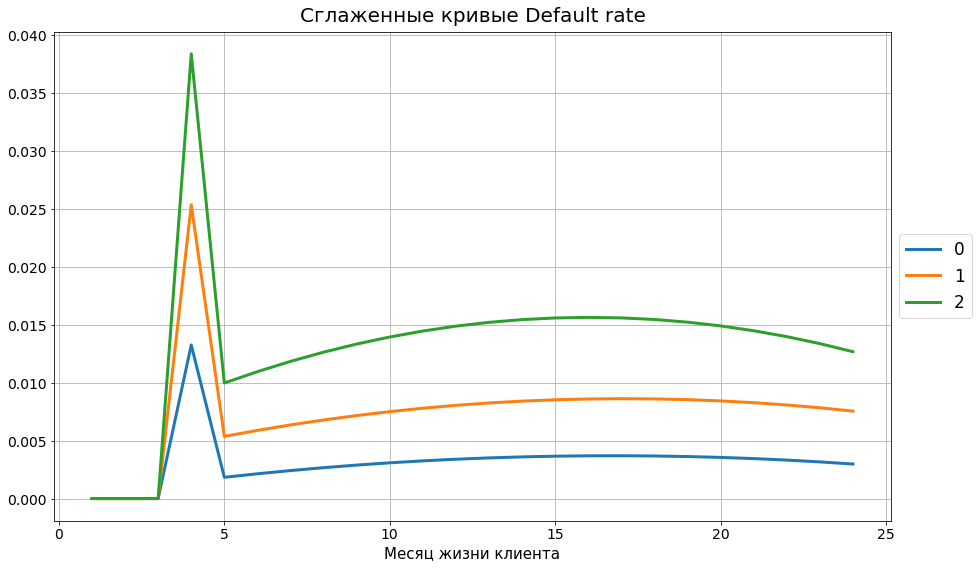

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['pd_bucket'].drop_duplicates().sort_values()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = default_rate_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 5,24,2)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Default rate", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

## Кривые DLQ ratio

Рассмотрим долю счетов в просрочке 1-3 ко всем активным счетам (активными называем счета находящихся в просрочке 0-3)
### $$DLQ ratio_n = \frac{\#DLQ_n}{\#ACT_n}$$

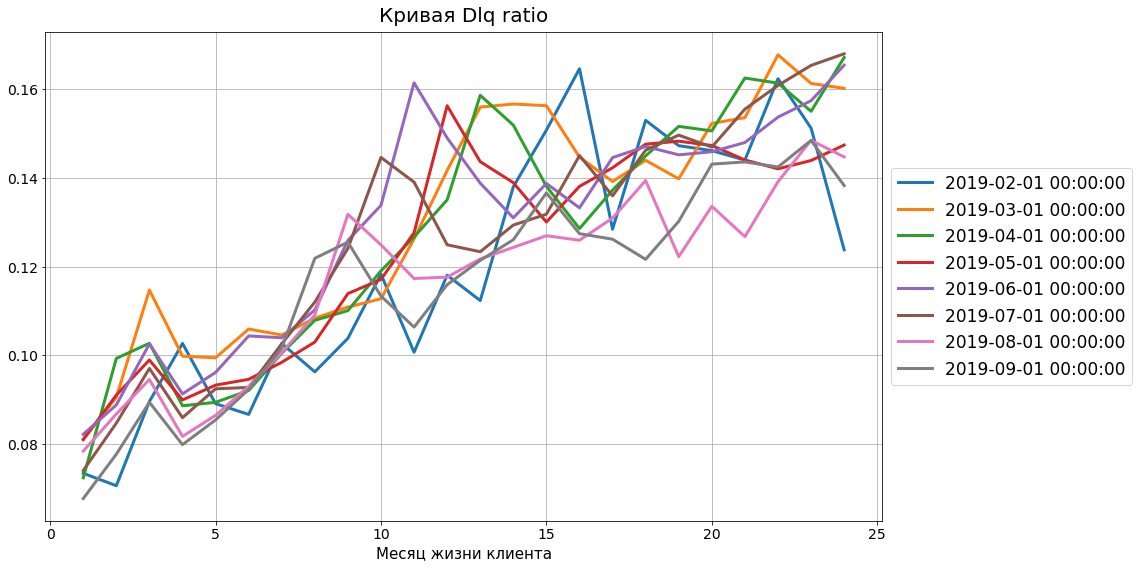

In [ ]:
# DLQ ratio будем рассматривать по месяцам. Для удобства и наглядости возьмем только часть наблюдений
df = df[df['gen_month_dt'] < '2019-10-01']

def plot_dlq_ratio_by_generation(df):
    return (df.groupby(["gen_month_dt", "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack('gen_month_dt')
            ['dlq_ratio']
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3))

# Строим график при помощи pyplot
plot_dlq_ratio_by_generation(df)

# Настраиваем параметры отображения графика
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

### Выберем параметр для разделения кривых

#### Разделение по PD

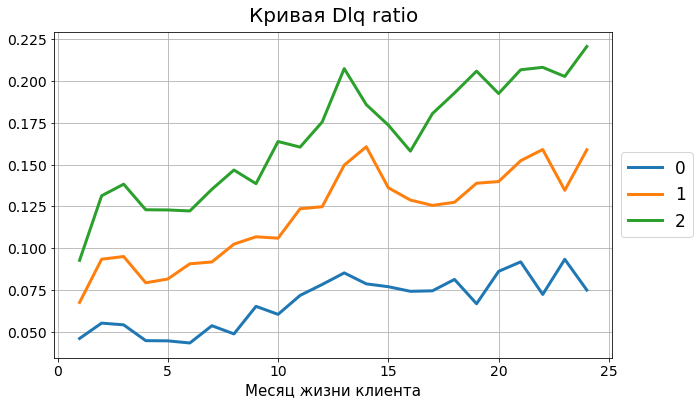

In [ ]:
def plot_dlq_ratio_by_bucket(df, bucket):
    return (df.query(''' gen_month_dt == '2019-04-01' ''')
            .groupby([bucket, "statement_num"])
            .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
            .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
            .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
            .unstack(bucket)
            ['dlq_ratio']
            .plot(ax=None, figsize=(10, 6), grid=True, lw = 3))

plot_dlq_ratio_by_bucket(df, 'pd_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Разделение по скору Х

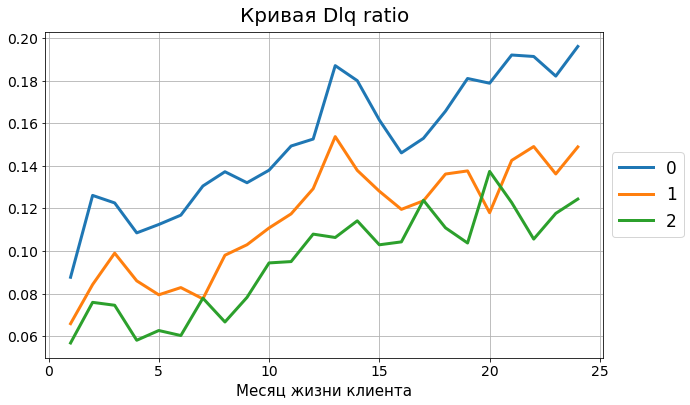

In [ ]:
plot_dlq_ratio_by_bucket(df, 'x_bucket')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### PD лучше разделяет кривые, поэтому будем использовать его

### Проверим выбору на странные поколения

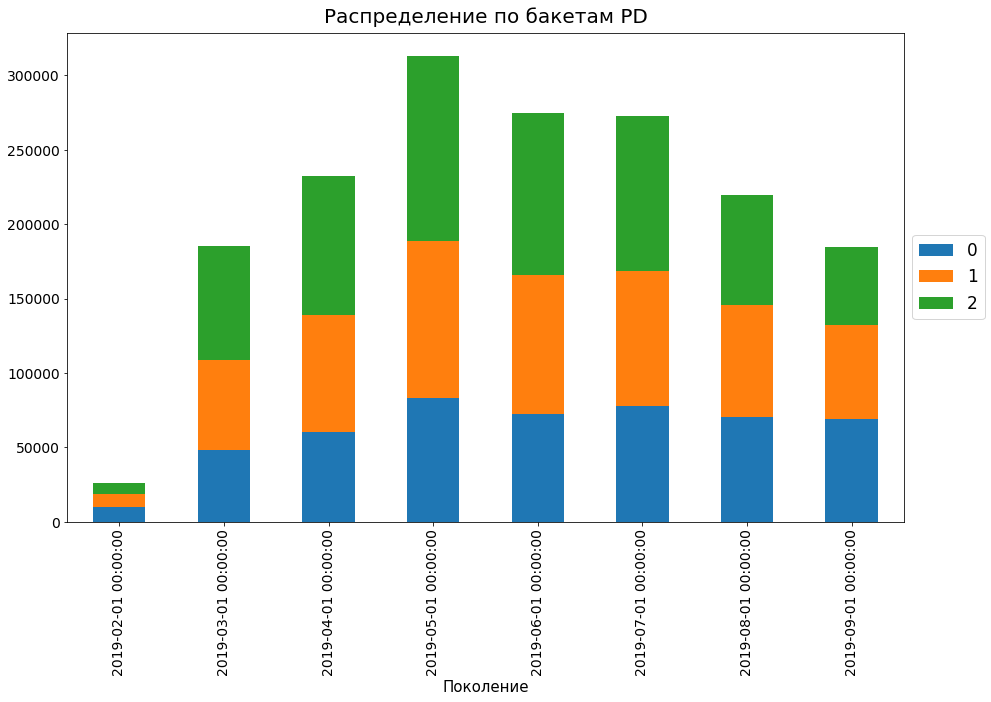

In [ ]:
def plot_distribution(df, bucket):
    return pd.pivot_table(df, index=[bucket], columns='gen_month_dt',          # делаем сводную таблицу и транспонируем ее
                values="user_id",
                aggfunc=np.count_nonzero, fill_value=0)\
               .T\
               .plot(kind='bar', stacked=True, figsize=(15, 9))                    # Рисуем график распределения столбиками

plot_distribution(df, 'pd_bucket')

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Распределение по бакетам PD", size=20, verticalalignment='bottom')
plt.xlabel("Поколение", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

Во феврале 2019 года мало наблюдений, исключим это поколение из рассмотрения

#### Рассмотрим поколения в разбивке по бакетам

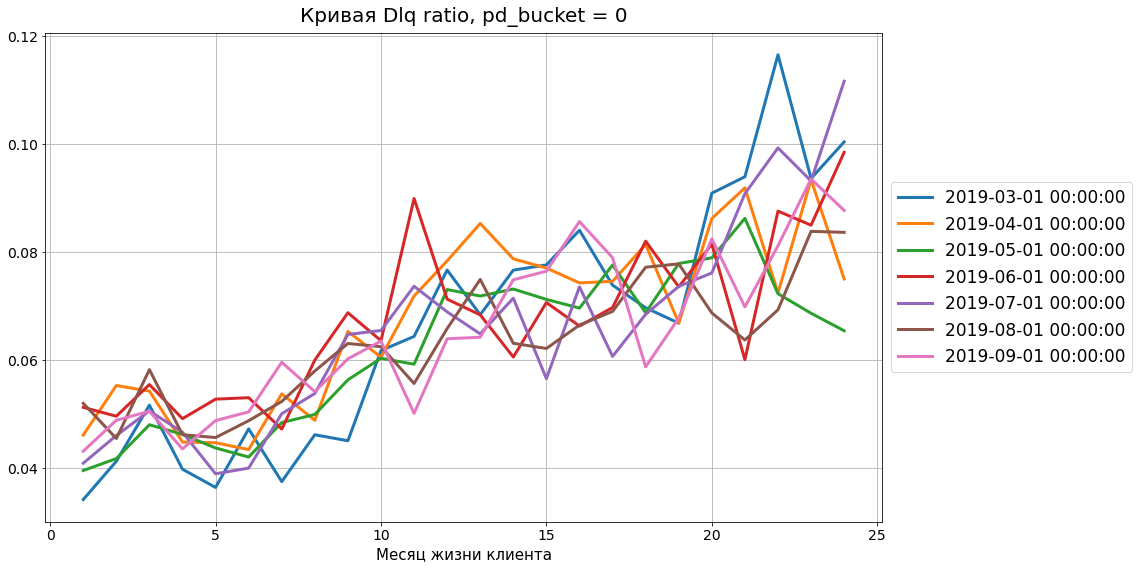

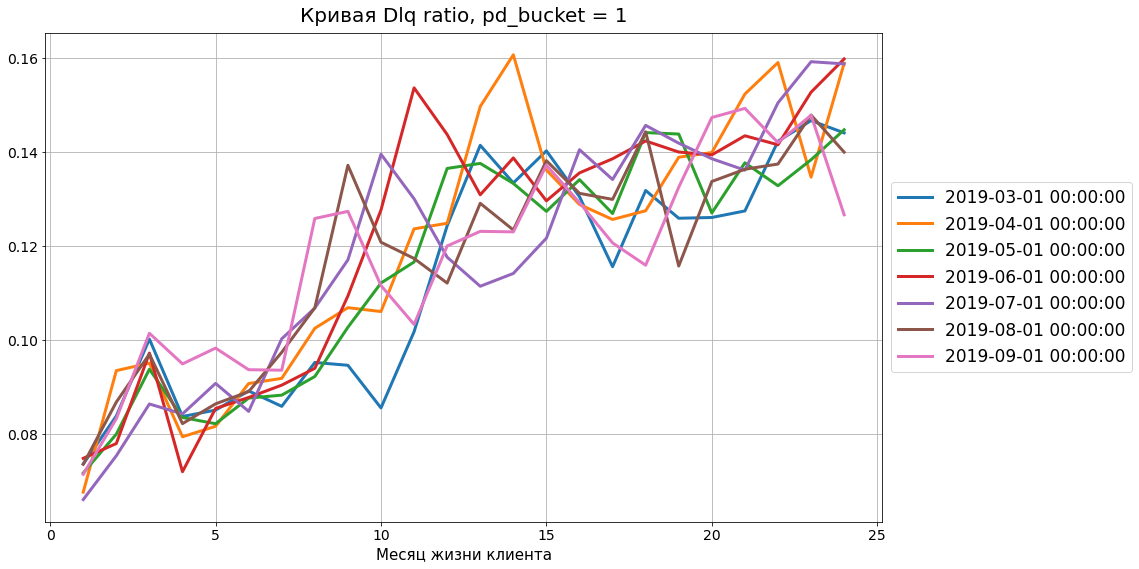

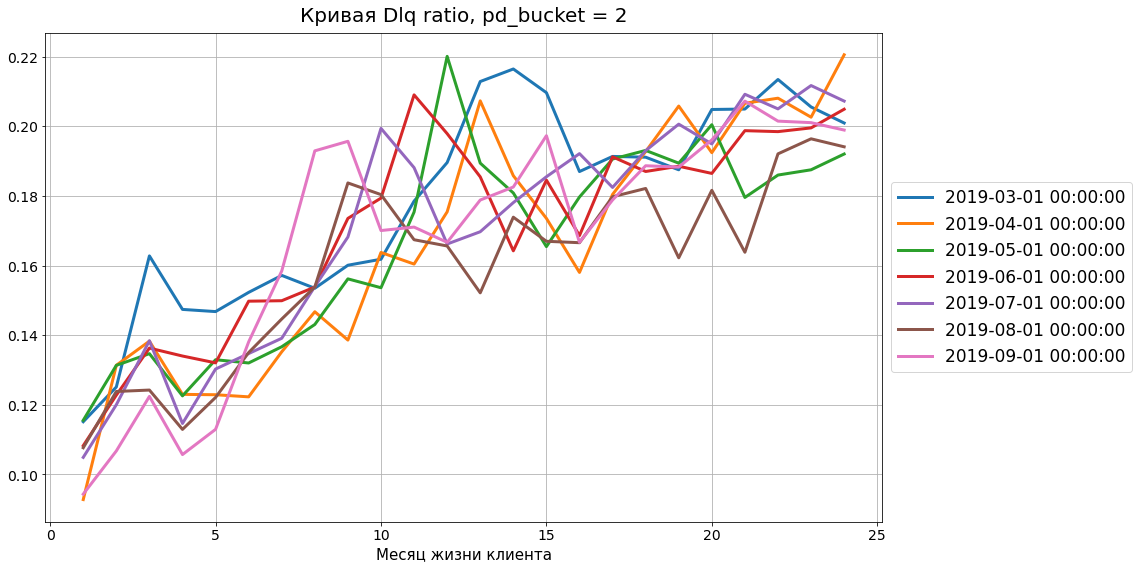

In [ ]:
# Исключаем плохое поколение

exception_query = ''' ~((gen_month_dt == '2019-02-01')) '''
df.query(exception_query, inplace = True)

# Делаем список бакетов

buckets = df['pd_bucket'].drop_duplicates().sort_values(ascending = True)


# Строим график, который зависит от бакета

def plot_dlq_ratio_by_generation(data, pd_bucket):
    data_tmp = data.query(''' pd_bucket == @pd_bucket''')\
        .groupby(["gen_month_dt", "statement_num"])\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)\
        .unstack('gen_month_dt')['dlq_ratio']\
        .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
    plt.title("Кривая Dlq ratio, pd_bucket = " + str(pd_bucket), size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)


for i in buckets:
    plot_dlq_ratio_by_generation(df, i)


## Вычищение макроэкономических воздействий

Видим, что в винтажах dlq ratio присутсвуют внешние воздействия. Вычистим их с помощью разложения винтажей на две матрицы.

##### Напомним идею разложения.

Сделаем обозначения:

$t$  - календарное время;

$n$  - номер поколения;

$(t−n)$  - месяц жизни клиента;


$D(t,n)$  - значения исследуемой кривой (Delinquency ratio) в месяц  $t$  для поколения номер  $n$ ;

$E(t)$  - внешние воздействия, которые зависят только от календарного времени  $t$ ;

$M(t−n)$  - кривая созревания, которая зависит только от месяца жизни клиента  $(t−n)$ .


Будем предполагать, что в идеальном случае существует разложение
$$D(n,t)=E(t)M(t−n)$$


Для поиска данного разложения будем минимизировать функционал
$$ F(E,M)=\sum_{n,t}{(D(t,n)−E(t)M(t−n))}^2 \to \min_{E,M} $$

где  $E={E(t),t>0}$, $M={M(t−n),t−n>0}$

#### Функции, которые реализую разложение матрицы

In [ ]:
def curve_build(data,
                feature,
                generation = 'generation_quart',
                statement_num = 'statement_num',
                group_label = '1'):

    """Вспомогательная функция для построения разложения в рамках одного бакета

    **Аргументы**
    data : pandas.DataFrame
        таблица с данными
    feature: str
        название поля с исследуемой переменной
    generation : datetime
        название поля с поколениями
    where : str
        условие, которым мы ограничиваем выборку
    statement_num : int
        название поля с номером месяца жизни клиента
    group_label : str
        название поля группы
    **Результат**
    dictionary : dict
    """

    df_query = data.sort_values([generation, statement_num]).reset_index()

    # Рассчитываем количество поколений и тому подобное
    generation_min = df_query[generation].min()
    gen_cnt = df_query[statement_num].max()

    # Преобразуем Dataframe в набор векторов
    values = np.array(df_query[feature])
    tab_size = df_query[feature].count()
    st_nums = np.array(df_query[statement_num] - 1)
    dates = np.array([0 for i in range(tab_size)])

    for i in range(tab_size):
         dates[i] = df_query.loc[i,generation].year * 12 + df_query.loc[i,generation].month -\
            generation_min.year * 12 - generation_min.month + df_query.loc[i,statement_num] - 1

    # Определяем функционал, который будем минимизировать

    def r_square(x):
        temp = 0
        for i in range(tab_size):
            if dates[i] >= 0:
                temp += (values[i] - x[dates[i]] * x[st_nums[i] + gen_cnt])**2
        return temp

    # Задаем callback для отслеживания прогресса минимизации
    def callbackF(Xi):
        global Nfeval
        print('%d  %.6f' % (Nfeval, r_square(Xi)))
        Nfeval += 1

    # Задаем начальное приближение в виде массива с нулевыми значениями

    x0 = np.array([0 for i in range(2*gen_cnt)])                                # Внешние воздействия

    # Численная минимизация

    print('Initial %.6f' % (r_square(x0)))
    res0 = minimize(r_square, x0, tol=1e-6, callback=callbackF, method='Powell', options = {'disp': False, 'maxiter': 1000})

    # Задаем датафрейм с внешними воздействиями
    external_data = pd.DataFrame({'month_dt': [generation_min + pd.DateOffset(months = i) for i in range(gen_cnt)],
                             group_label: res0.x[:gen_cnt]})

    # Нормируем внешние воздействия таким образом, чтобы в среднем они равнялись единице.
    ext_mean = external_data[external_data['month_dt'] > generation_min + pd.DateOffset(months = 6)][group_label].mean()
    external_data[group_label] = external_data[group_label] / ext_mean

    # И умножаем на полученный коэффициент кривые созревания

    maturation_array = np.transpose([res0.x[gen_cnt:2* gen_cnt] * ext_mean]).flatten()
    maturation_data = pd.DataFrame(data = {group_label: maturation_array, \
                                           'statement_num': np.arange(1,maturation_array.size + 1)})

    df_fitted = df_query.merge(right=external_data, on = 'month_dt')
    df_fitted['fitted_feature'] = df_fitted[feature] / df_fitted[group_label]

    # Формируем словарь c итоговыми данными
    res = {'res0': res0,
          'external_data': external_data,
          'maturation_data': maturation_data,
          'df_fitted': df_fitted}
    return res


def decomposition(df,
                  generation = 'generation_month',
                  group = 'bucket',
                  statement_num = 'statement_num',
                  feature = 'feature',
                  optimization_query = ''):
    """Винтажи исследуемой переменной по календарному времени

    **Аргументы**
    df : pandas.DataFrame
        таблица с данными
    generation : datetime
        название поля с поколениями
    group : str
        название поля с бакетами
    statement_num : int
        название поля с номером выписки
    feature: str
        название поля с исследуемой переменной
    optimization_query: str
        ограничение выборки для оптимизации
    **Результат**
    dictionary : dict
    """

    # Разбираемся со случаем пустых аргументов

    if optimization_query == '':
        df_query = pd.DataFrame(df)
    else:
        df_query = df.query(optimization_query)

    timedelta = df_query[statement_num].apply(lambda x: pd.DateOffset(months=x-1))
    df_query['month_dt'] = df_query[generation] + timedelta

      # Формируем список бакетов

    df_query.sort_values(by = [group], inplace = True)
    groups = pd.Series(df_query[group].drop_duplicates())

    # Запускаем цикл по бакетам
    i = 0
    for g in groups:
        df_temp = df_query[df_query[group] == g]
        print(group + ' = ' + str(g))

        # Строим разложение для одного бакета
        res = curve_build(df_temp,
                          feature = feature,
                          generation = generation,
                          statement_num = statement_num,
                          group_label = str(g)
                         )
        df_fitted_temp = pd.DataFrame(res['df_fitted'])
        df_fitted_temp[group] = g

        # Если первый шаг в цикле, то формируем датафреймы из результатов минимизации
        if i == 0:
            external_data = pd.DataFrame(res['external_data'])[['month_dt', str(g)]]
            maturation_data = pd.DataFrame(res['maturation_data'])[[statement_num, str(g)]]
            df_fitted = pd.DataFrame(df_fitted_temp)
        # Если шаг не первый, то дописываем столбцы в результаты
        else:
            external_data = external_data.merge(right = res['external_data'], on = ['month_dt'])
            maturation_data = maturation_data.merge(right = res['maturation_data'], on = [statement_num])
            df_fitted = pd.concat([df_fitted, df_fitted_temp])
        i+=1

    res_multiple = {
                    'external_data': external_data,
                    'maturation_data': maturation_data,
                    'fitted_data': df_fitted
                   }
    return res_multiple

#### Применим функцию к нашим данным

In [ ]:
# Подготавливаем данные
df_ratio = df.groupby(["pd_bucket","gen_month_dt", "statement_num"], as_index=False)\
        .agg({"dlq_flg":np.sum, "act_flg":np.sum, "user_id":np.count_nonzero})\
        .rename(columns = ({"dlq_flg":'dlq_cnt', "act_flg":'act_cnt', "user_id":"cnt"}))\
        .eval('dlq_ratio = dlq_cnt / act_cnt', inplace=False)


# Счетчик итераций
Nfeval = 0

# Проводим разложение кривых
res = decomposition(df_ratio,
                       generation = 'gen_month_dt',
                       group = 'pd_bucket',
                       statement_num = 'statement_num',
                       feature = 'dlq_ratio')

C:\Users\a.blokhina\AppData\Roaming\Python\Python37\site-packages\pandas\core\arrays\datetimelike.py:1190: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized
  PerformanceWarning,


pd_bucket = 0
Initial 0.761753
0  0.150455
1  0.148058
2  0.147692
3  0.147206
4  0.147159
5  0.146991
6  0.146922
7  0.146263
8  0.146039
9  0.144936
10  0.144431
11  0.142170
12  0.140739
13  0.133459
14  0.127018
15  0.101229
16  0.091744
17  0.084366
18  0.076935
19  0.044226
20  0.037828
21  0.023975
22  0.021740
23  0.015405
24  0.014457
25  0.010172
26  0.009808
27  0.009505
28  0.009245
29  0.008146
30  0.008123
31  0.008111
32  0.008102
33  0.008095
34  0.008053
35  0.008040
36  0.007971
37  0.007959
38  0.007906
39  0.007895
40  0.007815
41  0.007799
42  0.007730
43  0.007724
44  0.007719
45  0.007697
46  0.007694
47  0.007682
48  0.007680
49  0.007675
50  0.007675
51  0.007675
52  0.007674
53  0.007674
54  0.007674
55  0.007674
56  0.007674
pd_bucket = 1
Initial 2.423522
57  0.444476
58  0.437002
59  0.435970
60  0.435300
61  0.433367
62  0.432983
63  0.427332
64  0.425227
65  0.409377
66  0.401793
67  0.345749
68  0.306221
69  0.160959
70  0.136248
71  0.096683
72  0.080960

#### Получившиеся кривые внешних воздействий

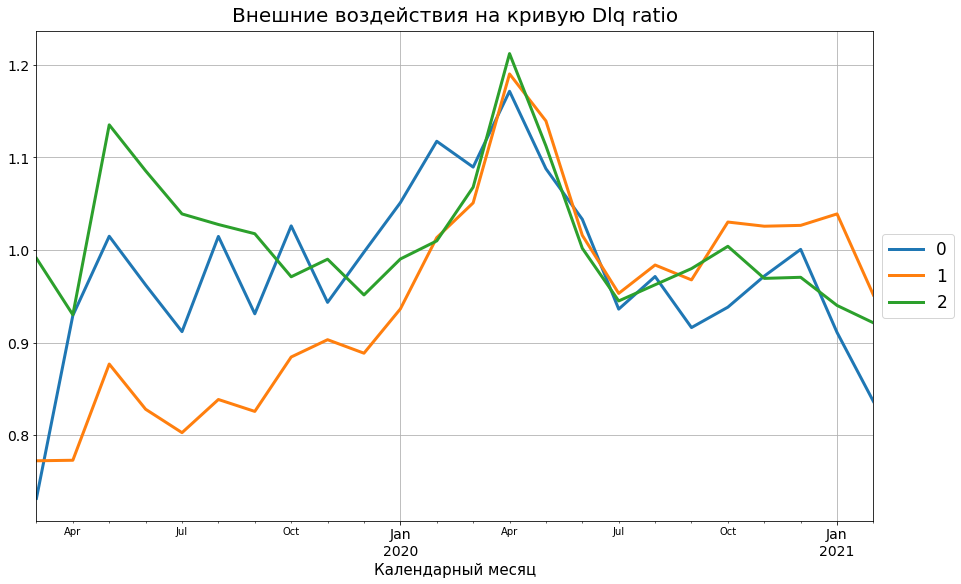

In [ ]:
res['external_data'].set_index('month_dt')\
                    .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Внешние воздействия на кривую Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Календарный месяц", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Кривые DLQ ratio, вычищенные от внешних воздействий

C:\Users\a.blokhina\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


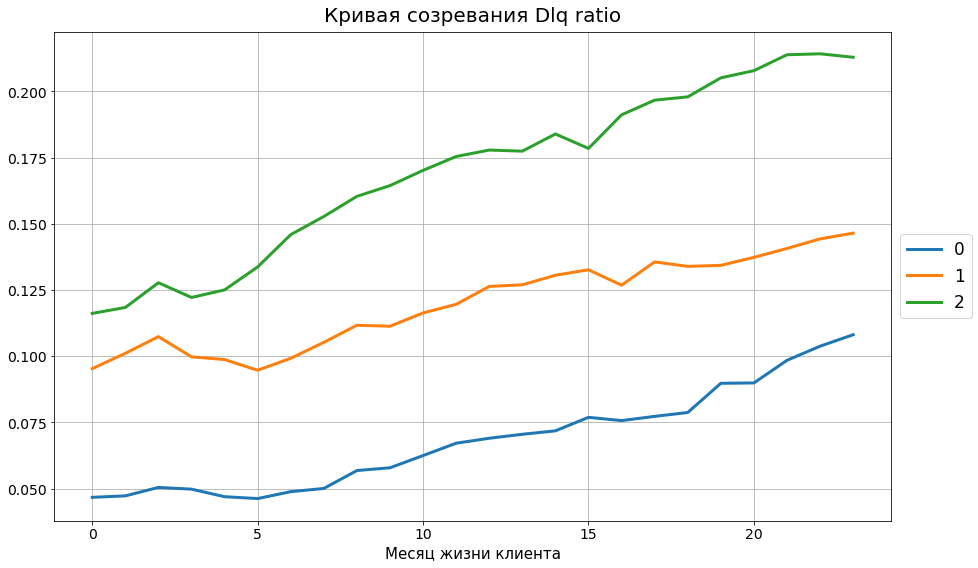

In [ ]:
res['maturation_data'].drop('statement_num', 1).plot(ax=None, figsize=(15, 9), grid=True, lw = 3)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая созревания Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Вычищенные кривые в разбивке по поколениям

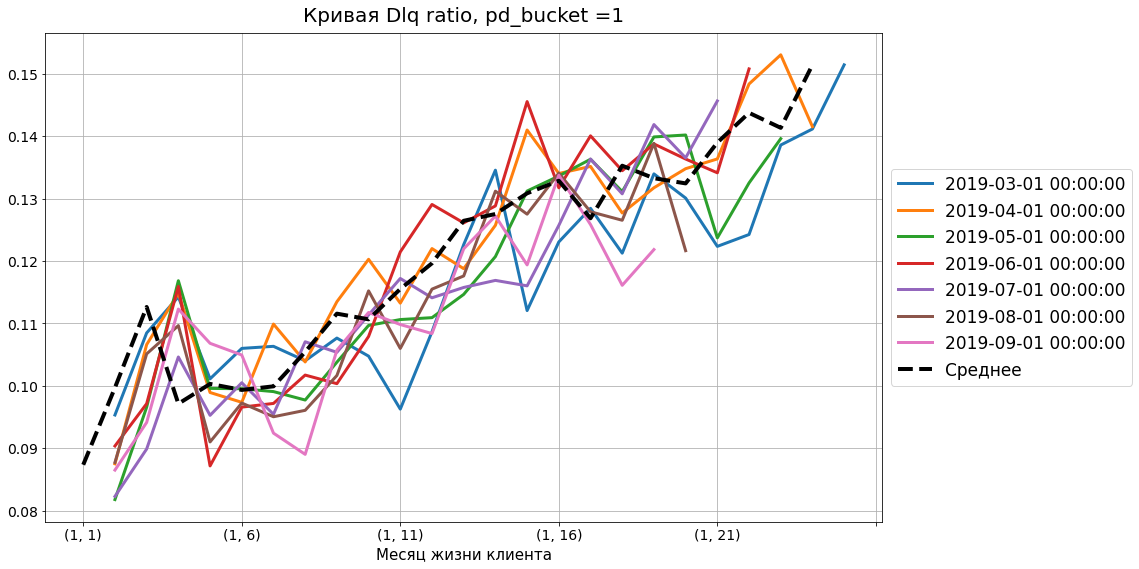

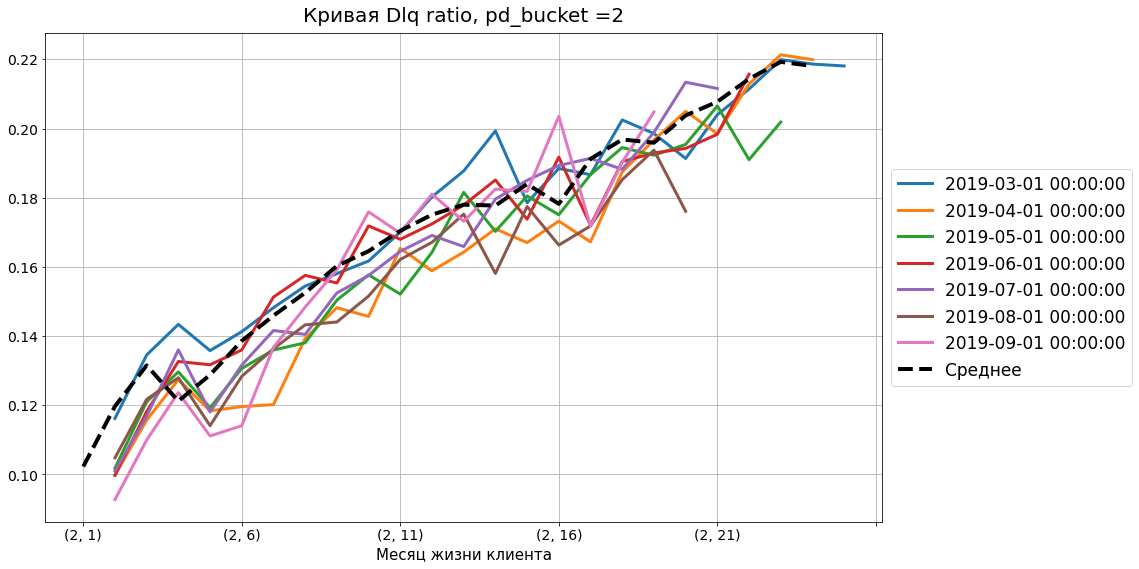

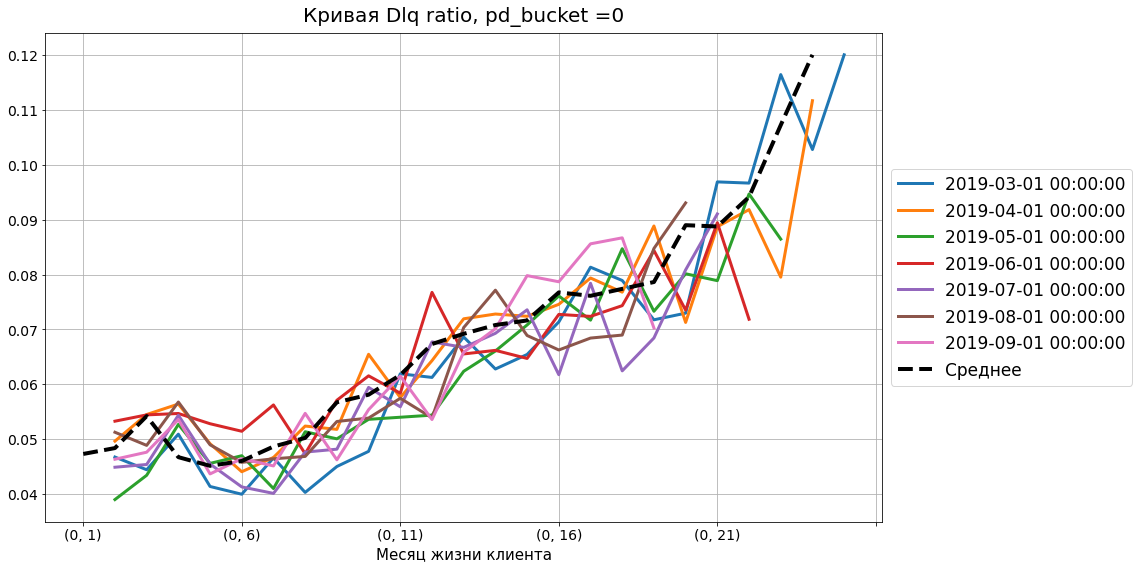

In [ ]:
# Считаем среднее

dlq_ratio_mean = res['fitted_data'].groupby([ 'pd_bucket', 'statement_num'])\
    .agg({'fitted_feature':np.mean})\
    .rename(columns = {'fitted_feature':'Среднее'})

buckets = df['pd_bucket'].drop_duplicates()

# Строим графики винтажей и среднего

def plot_dlq_ratio_mean(pd_bucket):
    vintages_graph = res['fitted_data'].query('pd_bucket == ' + str(pd_bucket))\
            .groupby(["gen_month_dt", "statement_num"])\
            .agg({"fitted_feature":np.sum})\
            .unstack('gen_month_dt')\
            ['fitted_feature']\
            .plot(ax=None, figsize=(15, 9), grid=True, lw = 3)                                             # график винтажей
    (dlq_ratio_mean.query('pd_bucket == ' + str(pd_bucket))['Среднее']
             .plot( figsize=(15, 9), grid=True, lw = 4, color = 'Black', ls = 'dashed'))  # Подаем график винтажей в ось другого,
    plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')                                 # чтобы отобразить их вместе
    plt.title("Кривая Dlq ratio, pd_bucket =" + str(pd_bucket), "", size=20, verticalalignment='bottom')
    plt.xlabel("Месяц жизни клиента", size=15)
    plt.tick_params(axis='both', which='major', labelsize=14)

for i in buckets:
    plot_dlq_ratio_mean(i)

### Найдем лучшую функцию для сглаживания кривых

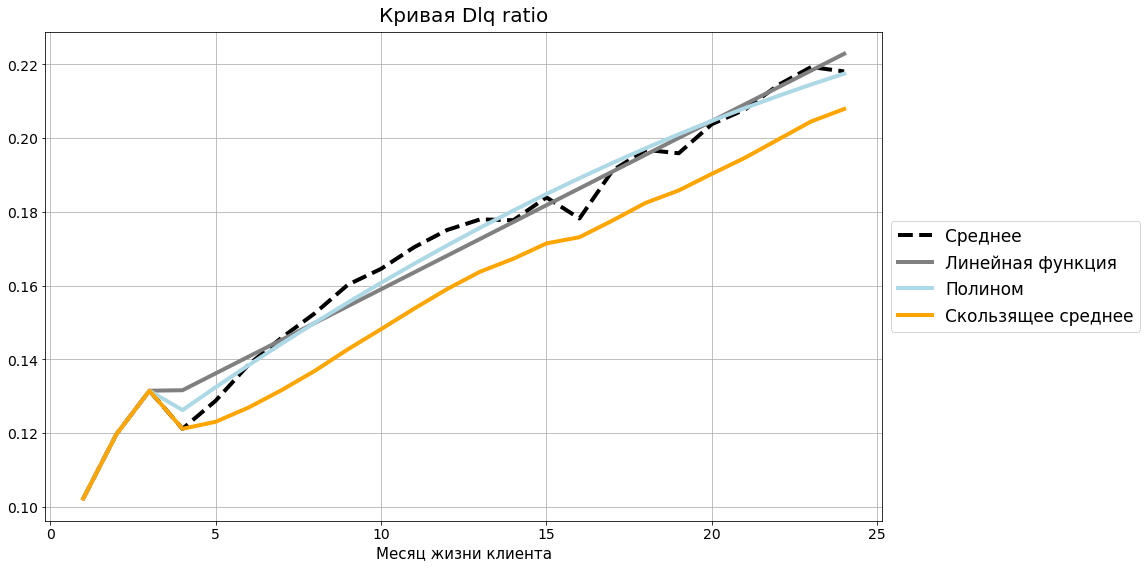

In [ ]:
df_linear = dlq_ratio_mean.query('pd_bucket == 2').reset_index().set_index(['statement_num'])
df_linear = linear_approximation(df_linear, 4, 24)
df_polynom = polynom_approximation(df_linear, 4,24,2)
df_smooth = exponential_smoothing(df_polynom, 4,24, 0.25)

# Строим получившиеся графики
plt.figure(figsize=(15, 9))
df_smooth['Среднее'].plot(grid=True, color = 'Black', linestyle = '--', lw = 4)
df_smooth['Линейная функция'].plot(grid=True, color = 'Gray', linestyle = '-', lw = 4)
df_smooth['Полином'].plot(grid=True, color = 'LightBlue', linestyle = '-', lw = 4)
df_smooth['Скользящее среднее'].plot(grid=True, color = 'Orange', linestyle = '-', lw = 4)

plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Кривая Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)

#### Для приближения воспользуемся полиномом и сгладим все кривые

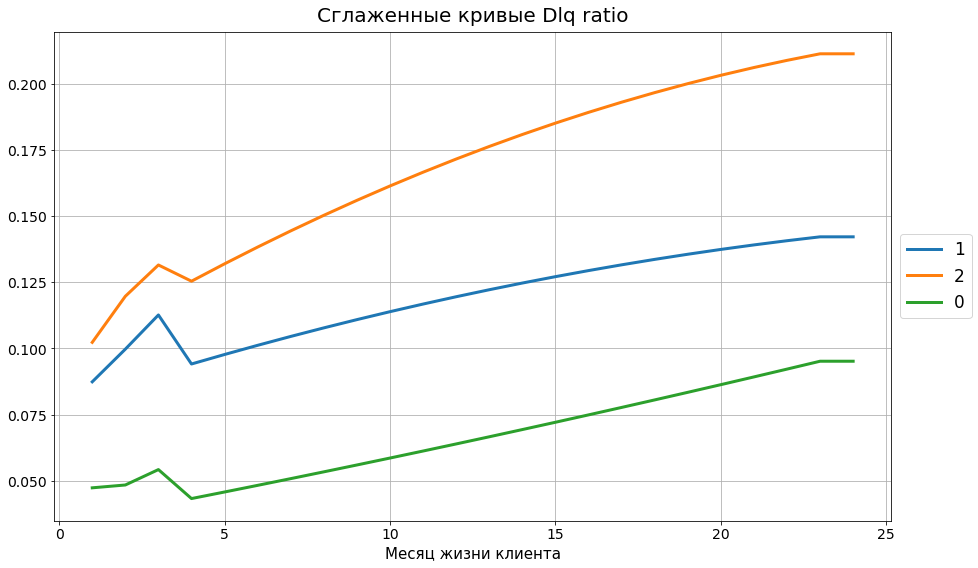

In [ ]:
# Запоминаем набор бакетов и заводим пустой датафрейм под результат

buckets = df['pd_bucket'].drop_duplicates()
df_smooth_result = pd.DataFrame()

# Далем полиномиальное сглаживание для каждого бакета
for bucket in buckets:
    df_temp = dlq_ratio_mean.query('pd_bucket == ' + str(bucket)).reset_index().set_index(['statement_num'])
    df_smooth_result[str(bucket)] = polynom_approximation(df_temp, 4,22,2)['Полином']

# Строим итоговый график
df_smooth_result.plot(figsize=(15, 9), grid=True, lw = 3)
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5), fontsize = '17')
plt.title("Сглаженные кривые Dlq ratio", size=20, verticalalignment='bottom')
plt.xlabel("Месяц жизни клиента", size=15)
plt.tick_params(axis='both', which='major', labelsize=14)